如果读者一直按照本书的顺序读到这里，很可能已经使用了优化算法来训练深度学习模型。具体来说，在训练模型时，我们会使用优化算法不断迭代模型参数以最小化模型的损失函数。当迭代终止时，模型的训练随之终止。此时的模型参数就是模型通过训练所学习到的参数。

优化算法对于深度学习十分重要。一方面，如图7.1所表现的那样，训练一个复杂的深度学习模型可能需要数小时、数日、甚至数周时间。而优化算法的表现直接影响模型训练效率。另一方面，理解各种优化算法的原理以及其中各参数的意义将有助于我们更有针对性地调参，从而使深度学习模型表现地更好。

本章将详细介绍深度学习中的常用优化算法。

![漫画：训练深度学习模型](../img/training_model.png)


# 优化算法概述

本节将讨论优化与深度学习的关系以及优化在深度学习中的挑战。


## 优化与深度学习

在一个深度学习问题中，通常我们会预先定义一个损失函数。有了损失函数以后，我们就可以使用优化算法试图使其最小化。在优化中，这样的损失函数通常被称作优化问题的目标函数（objective function）。依据惯例，优化算法通常只考虑最小化目标函数。其实，任何最大化问题都可以很容易地转化为最小化问题：我们只需把目标函数前面的正号或负号取相反。

虽然优化为深度学习提供了最小化损失函数的方法，但本质上，这两者之间的目标是有区别的。
在[欠拟合和过拟合](../chapter_supervised-learning/underfit-overfit.md)一节中，我们区分了训练误差和泛化误差。
由于优化算法的目标函数通常是一个基于训练数据集的损失函数，优化的目标在于降低训练误差。
而深度学习的目标在于降低泛化误差。
为了降低泛化误差，除了使用优化算法降低训练误差以外，我们还需要注意应对过拟合。

本章中，我们只关注优化算法在最小化目标函数上的表现，而不关注模型的泛化误差。



## 优化在深度学习中的挑战

绝大多数深度学习中的目标函数都很复杂。因此，很多优化问题并不存在解析解，而需要使用基于数值方法的优化算法找到近似解。这类优化算法一般通过不断迭代更新解的数值来找到近似解。我们讨论的优化算法都是这类基于数值方法的算法。

优化在深度学习中有很多挑战。以下描述了其中的两个挑战：局部最小值和鞍点。为了更好地描述问题，我们先导入本节中实验需要的包。

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
sys.path.append('..')
import utils

### 局部最小值

对于目标函数$f(x)$，如果$f(x)$在$x$上的值比在$x$邻近的其他点的值更小，那么$f(x)$可能是一个局部最小值（local minimum）。如果$f(x)$在$x$上的值是目标函数在整个定义域上的最小值，那么$f(x)$是全局最小值（global minimum）。

举个例子，给定函数

$$f(x) = x \cdot \text{cos}(\pi x), \qquad -1.0 \leq x \leq 2.0,$$

我们可以大致找出该函数的局部最小值和全局最小值的位置。需要注意的是，图中箭头所指示的只是大致位置。

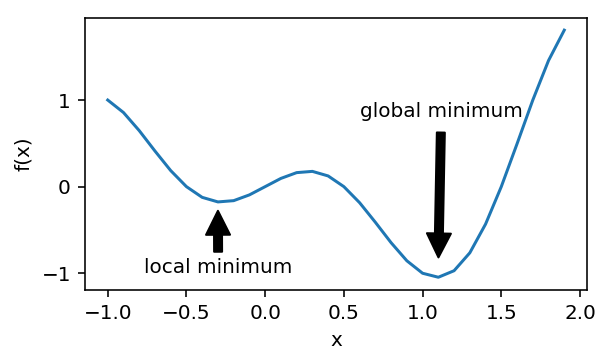

In [2]:
def f(x):
    return x * np.cos(np.pi * x)

utils.set_fig_size(mpl, (4.5, 2.5))
x = np.arange(-1.0, 2.0, 0.1)
fig = plt.figure()
subplt = fig.add_subplot(111)
subplt.annotate('local minimum', xy=(-0.3, -0.25), xytext=(-0.77, -1.0),
                arrowprops=dict(facecolor='black', shrink=0.05))
subplt.annotate('global minimum', xy=(1.1, -0.9), xytext=(0.6, 0.8),
                arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot(x, f(x))
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

深度学习模型的目标函数可能有若干局部最优值。当一个优化问题的数值解在局部最优解附近时，由于目标函数有关解的梯度接近或变成零，最终迭代求得的数值解可能只令目标函数局部最小化而非全局最小化。


### 鞍点

刚刚我们提到，梯度接近或变成零可能是由于当前解在局部最优解附近所造成的。事实上，另一种可能性是当前解在鞍点（saddle point）附近。举个例子，给定函数

$$f(x) = x^3,$$

我们可以找出该函数的鞍点位置。

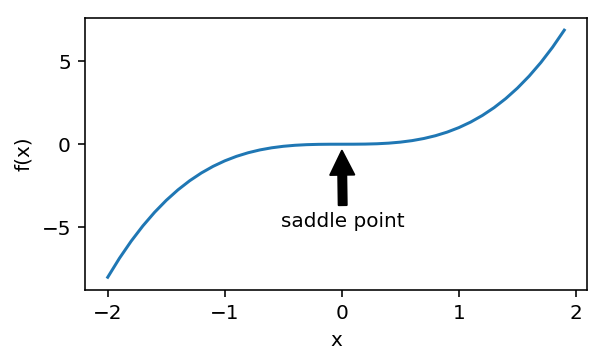

In [3]:
x = np.arange(-2.0, 2.0, 0.1)
fig = plt.figure()
subplt = fig.add_subplot(111)
subplt.annotate('saddle point', xy=(0, -0.2), xytext=(-0.52, -5.0),
                arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot(x, x**3)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

再举个定义在二维空间的函数的例子，例如

$$f(x, y) = x^2 - y^2.$$

我们可以找出该函数的鞍点位置。也许读者已经发现了，该函数看起来像一个马鞍，而鞍点恰好是马鞍上可坐区域的中心。

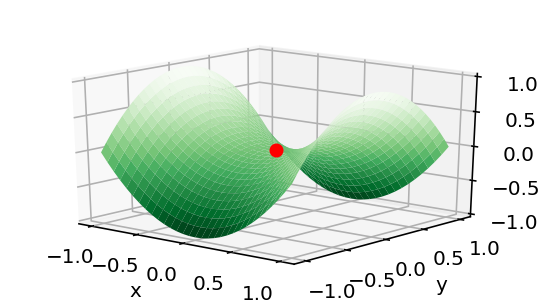

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y = np.mgrid[-1:1:31j, -1:1:31j]
z = x**2 - y**2
ax.plot_surface(x, y, z, **{'rstride': 1, 'cstride': 1, 'cmap': "Greens_r"})
ax.plot([0], [0], [0], 'ro')
ax.view_init(azim=-50, elev=20)
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.yticks([-1, -0.5, 0, 0.5, 1])
ax.set_zticks([-1, -0.5, 0, 0.5, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

在上图的鞍点位置，目标函数在$x$轴上是局部最小值，而在$y$轴上是局部最大值。假设目标函数在一个维度为$k$的点上可能是局部最小值、局部最大值或者是鞍点（梯度为零）。想象一下，如果目标函数在该点任意维度上是局部最小值或者局部最大值的概率分别是0.5，该点为目标函数局部最小值的概率为$0.5^k$。事实上，由于深度学习模型参数通常都是高维的，目标函数的鞍点通常比局部最小值更常见。


## 小结

深度学习中，虽然找到目标函数的全局最优解很难，但这并非必要。我们将在接下来的章节中逐一介绍深度学习中常用的优化算法，它们在很多实际问题中都训练出了十分有效的深度学习模型。


## 练习

* 你还能想到哪些深度学习中的优化问题的挑战？


## 扫码直达[讨论区](https://discuss.gluon.ai/t/topic/1876)


![](../img/qr_optimization-intro.svg)